In [2]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm
from sklearn.metrics import r2_score
from pygad import GA

from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore, get_data_graph, get_data_megnet
from utils.dataloading import get_data, get_graph_data

In [3]:
import matplotlib as mpl

In [4]:
plt.rc('font', family='serif',)

In [5]:
from matplotlib import rc

In [6]:
data = get_zeolite('MFI', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'MFI')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [7]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [8]:
atoms.shape[0]

3296

In [9]:
title_size=7.5
label_size=7

In [10]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, out_size=2).to('cuda')

mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True, out_size=2).to('cuda')

In [11]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [12]:
_mae_p_hoa = []
_mae_p_henry = []
_mse_p_hoa = []
_mse_p_henry = []
_r2_p_hoa = []
_r2_p_henry = []


_mae_p2_hoa = []
_mse_p2_hoa = []
_mae_p2_henry = []
_mse_p2_henry = []
_r2_p2_hoa = []
_r2_p2_henry = []
    
for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/MFI/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)
    y_true[:,1] = torch.log10(y_true[:,1])

    _mse = ((y_pred - y_true)**2)#.mean().item()
    _mae = (y_pred - y_true).abs()#.mean().item()

    _r2_hoa = r2_score(y_true[:,0].numpy(), y_pred[:,0].numpy())
    _r2_henry = r2_score(y_true[:,1].numpy(), y_pred[:,1].numpy())

    _mae_hoa = _mae[:,0].mean().item()
    _mae_henry = _mae[:,1].mean().item()
    _mse_hoa = _mse[:,0].mean().item()
    _mse_henry = _mse[:,1].mean().item()
    
    _mae_p_hoa.append(_mae_hoa)
    _mae_p_henry.append(_mae_henry)
    _mse_p_hoa.append(_mse_hoa)
    _mse_p_henry.append(_mse_henry)
    _r2_p_hoa.append(_r2_hoa)
    _r2_p_henry.append(_r2_henry)

    mpnn2.load_state_dict(torch.load(f'model_data_random2/MFI/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)
    y_true[:,1] = torch.log10(y_true[:,1])
    
    _mse = ((y_pred - y_true)**2)#.mean().item()
    _mae = (y_pred - y_true).abs()#.mean().item()


    _r2_hoa = r2_score(y_true[:,0].numpy(), y_pred[:,0].numpy())
    _r2_henry = r2_score(y_true[:,1].numpy(), y_pred[:,1].numpy())

    _mae_hoa = _mae[:,0].mean().item()
    _mae_henry = _mae[:,1].mean().item()
    _mse_hoa = _mse[:,0].mean().item()
    _mse_henry = _mse[:,1].mean().item()
    
    
    _mae_p2_hoa.append(_mae_hoa)
    _mae_p2_henry.append(_mae_henry)
    _mse_p2_hoa.append(_mse_hoa)
    _mse_p2_henry.append(_mse_henry)
    _r2_p2_hoa.append(_r2_hoa)
    _r2_p2_henry.append(_r2_henry)

mae_p_hoa  = np.mean(_mae_p_hoa)
mse_p_hoa = np.mean(_mse_p_hoa)
r2_p_hoa = np.mean(_r2_p_hoa)
mae_p2_hoa  = np.mean(_mae_p2_hoa)
mse_p2_hoa = np.mean(_mse_p2_hoa)
r2_p2_hoa = np.mean(_r2_p2_hoa)

mae_p_henry  = np.mean(_mae_p_henry)
mse_p_henry = np.mean(_mse_p_henry)
r2_p_henry = np.mean(_r2_p_henry)
mae_p2_henry  = np.mean(_mae_p2_henry)
mse_p2_henry = np.mean(_mse_p2_henry)
r2_p2_henry = np.mean(_r2_p2_henry)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:41<00:00, 10.15s/it]


In [13]:
maes = [_mae_p_hoa, _mae_p2_hoa, _mae_p_henry, _mae_p2_henry]
mses = [_mse_p_hoa, _mse_p2_hoa, _mse_p_henry, _mse_p2_henry]
r2s = [_r2_p_hoa, _r2_p2_hoa, _r2_p_henry, _r2_p2_henry]

In [14]:
df = pd.DataFrame(columns = ['MAE','MSE','R2'], index=['EPCN (hoa)','Ours (hoa)','EPCN (henry)', 'Ours (henry)'])
for i in range(len(df.index)):

    mu_a = np.mean(maes[i]).round(2)
    mu_s = np.mean(mses[i]).round(2)
    mu_r = np.mean(r2s[i]).round(2)
    
    ci_a = get_95_CI(maes[i]).round(2)
    ci_s = get_95_CI(mses[i]).round(2)
    ci_r = get_95_CI(r2s[i]).round(2)
    
    a = fr'{mu_a} $$\pm$$ {ci_a}'
    s = fr'{mu_s} $$\pm$$ {ci_s}'
    r = fr'{mu_r} $$\pm$$ {ci_r}'
    
    df.loc[df.index[i]] = [a,s,r]

In [15]:
df

,MAE,MSE,R2
EPCN (hoa),2.0 $$\pm$$ 0.04,8.76 $$\pm$$ 0.31,0.83 $$\pm$$ 0.01
Ours (hoa),2.06 $$\pm$$ 0.04,9.52 $$\pm$$ 0.43,0.81 $$\pm$$ 0.01
EPCN (henry),0.16 $$\pm$$ 0.01,0.05 $$\pm$$ 0.01,0.88 $$\pm$$ 0.02
Ours (henry),0.16 $$\pm$$ 0.02,0.05 $$\pm$$ 0.01,0.87 $$\pm$$ 0.02


In [16]:
best_idx = np.argmin(_mae_p2_hoa)
mpnn2.load_state_dict(torch.load(f'model_data_random2/MFI/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn2.predict(testloader)
y_pred = y_pred.numpy()
y_true = y_true.numpy()
y_true[:,1] = np.log10(y_true[:,1])

In [17]:
np.save('pred_mfi.npy', y_pred)

In [18]:
np.save('true_mfi.npy', y_true)

In [19]:
np.save('ats_mfi.npy',testloader.dataset.X.numpy())

In [20]:
from scipy.interpolate import griddata
from scipy.stats import gaussian_kde

In [21]:
_X = X[X[:,1]>0.75]

color = np.zeros((_X.shape[0],))
for i in range(len(_X)):

    yy = False
    for j in range(12):
        
        for k in range(ref.shape[0]):
            
            if np.abs(_X[i] - (np.mod(ref[k]*X[j] + tra[k], 1))).sum() < 0.01:
            # if (X[i] == (np.mod(ref[k]*X[j] + tra[k], 1))).all():
                
                color[i] = j
                yy = True  
                break

    if yy is not True:
        color[i] = -1


In [22]:
color2 = np.zeros((X_pore.shape[0]-2,))
for i in range(len(X_pore)-2):
    
    for j in range(len(X_pore)-2):
        
        for k in range(ref.shape[0]):

            if np.abs(X_pore[i] - (np.mod(ref[k]*X_pore[j] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break
        

In [23]:
_A = A[X[:,1]>0.75]
_A = _A[:,X[:,1]>0.75]

In [24]:
ce_dict = {}
row, col = np.nonzero(_A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = _X[test[0]]
        test_c = _X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*_X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*_X[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [25]:
_A_pore = A_pore[X[:,1]>0.75]

In [26]:
cp_dict = {}
row, col = np.nonzero(_A_pore[:,:12])
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = _X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(ref[k]*_X[r] + tra[k], 1)
            r2 = np.mod(ref[k]*X_pore[c] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [27]:
import matplotlib.patheffects as pe

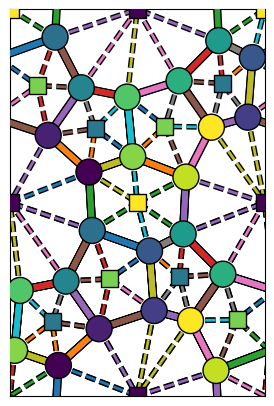

In [28]:
plt.figure(figsize=(13.142/4,20.09/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = _X[j[0]].copy(), _X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[2], x2[2]], [x1[0], x2[0]], lw=4, zorder=5)
            plt.plot([x1[2], x2[2]], [x1[0], x2[0]], lw=6, c='black', zorder=4)

            plt.plot([x1[2]-1, x2[2]-1], [x1[0], x2[0]], c= line[0].get_c(), lw=4, zorder=5)
            plt.plot([x1[2]-1, x2[2]-1], [x1[0], x2[0]], lw=6, c='black', zorder=4)

            plt.plot([x1[2]+1, x2[2]+1], [x1[0], x2[0]], c= line[0].get_c(), lw=4, zorder=5)
            plt.plot([x1[2]+1, x2[2]+1], [x1[0], x2[0]], lw=6, c='black', zorder=4)
        
        plt.plot([x1[2], x2[2]], [x1[0], x2[0]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[2], x2[2]], [x1[0], x2[0]], c= 'black',lw=6, zorder=4)
        plt.plot([x1[2]-1, x2[2]-1], [x1[0], x2[0]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[2]-1, x2[2]-1], [x1[0], x2[0]], c= 'black',lw=6, zorder=4)
        plt.plot([x1[2]+1, x2[2]+1], [x1[0], x2[0]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[2]+1, x2[2]+1], [x1[0], x2[0]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = _X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[2], x2[2]], [x1[0], x2[0]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
            plt.plot([x1[2]-1, x2[2]-1], [x1[0], x2[0]],lw=2,ls='--', c= line[0].get_c(), path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
            plt.plot([x1[2]+1, x2[2]+1], [x1[0], x2[0]],lw=2,ls='--', c= line[0].get_c(), path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        
        plt.plot([x1[2], x2[2]], [x1[0], x2[0]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        plt.plot([x1[2]-1, x2[2]-1], [x1[0], x2[0]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        plt.plot([x1[2]+1, x2[2]+1], [x1[0], x2[0]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:12,2], X_pore[:12,0], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:12,2]+1, X_pore[:12,0], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:12,2], X_pore[:12,0]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:12,2]+1, X_pore[:12,0]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(_X[:,2], _X[:,0], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_mfi.pdf', bbox_inches='tight', dpi=1200);
plt.savefig('figures/weight_sharing_pore_mfi.png', bbox_inches='tight', dpi=1200);

In [29]:
atsum = trainloader.dataset.X.sum((1,2))

In [30]:
hoa_train = trainloader.dataset.y

In [31]:
uniq = atsum.unique()

In [32]:
hoa_min = np.zeros_like(uniq, dtype=float)
hoa_max = np.zeros_like(uniq, dtype=float)

In [33]:
for ue in range(len(uniq)):
    hoa_min[ue] = hoa_train[atsum==uniq[ue]].min()
    hoa_max[ue] = hoa_train[atsum==uniq[ue]].max()

In [34]:
beta = 1
def fitness_function(ga_instance, solution, solution_idx):
    atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
    gen_net.eval()
    with torch.no_grad():
        curr_hoa = gen_net.forward(atoms).item()
    fitness = - (curr_hoa-target_hoa)**2 - beta*sum(solution)
    return fitness

In [35]:
# n_pops =32
struct_per_hoa = 10
target_hoas = np.arange(40, 71)

In [36]:
new_structures = np.zeros((struct_per_hoa*len(target_hoas), 96))
pred_hoas = np.zeros((struct_per_hoa*len(target_hoas)))

In [37]:
import torch.nn as nn
class GeneticNet(nn.Module):

    def __init__(self, mpnn, edges, pore, bonds_sp, bonds_ps):
        
        super().__init__()
        self.bonds = edges[None].float().cuda().repeat(2,1,1)
        self.sites_p = torch.tensor(pore[None]).float().cuda().repeat(2,1,1)
        self.bonds_sp = edges_sp[None].float().cuda().repeat(2,1,1)
        self.bonds_ps = edges_ps[None].float().cuda().repeat(2,1,1)

        self.mpnn = mpnn
    @torch.no_grad()
    def forward(self, atoms):
        return self.mpnn(atoms, self.bonds, self.sites_p, self.bonds_sp, self.bonds_ps)[0,:,0].sum()
gen_net = GeneticNet(mpnn2, edges, pore, edges_sp, edges_ps,).cuda()

In [38]:
for i in tqdm(range(len(target_hoas))):
    for j in range(struct_per_hoa):

        target_hoa = target_hoas[i]
        n_pops = 32
        initial_population = np.zeros((n_pops, 96))
        for k in range(len(initial_population)):
            n_atoms = uniq[np.logical_and(hoa_min <= target_hoa, hoa_max >= target_hoa)]
            if target_hoa > hoa_max.max():
                n_atoms=[12]
            elif target_hoa < hoa_min.min():
                n_atoms=[0]
            n = np.random.choice(n_atoms)
            idxes = np.random.choice(np.arange(96), size=n, replace=False)
        
            for l in idxes:
                initial_population[k,l] = 1
        
        ga_instance = GA(num_generations=50,
                 num_parents_mating=2,
                 initial_population=initial_population,
                 fitness_func=fitness_function,
                 crossover_probability=0.2,
                 keep_elitism=5,
                 save_best_solutions=True,
                 gene_space=[0, 1])
        
        ga_instance.run()
        solution = ga_instance.best_solutions[-1]
        atoms = torch.tensor(solution)[None,:,None].repeat(2,1,1).float().cuda()
        gen_net.eval()
        curr_hoa = gen_net.forward(atoms).item()

        idx = i*struct_per_hoa + j
        new_structures[idx] = solution
        pred_hoas[idx] = curr_hoa

np.save('Genetic Algorithm Results/structures_mfi.npy', new_structures)
np.save('Genetic Algorithm Results/pred_hoas_mfi.npy', pred_hoas)

  0%|                                                                                           | 0/31 [00:00<?, ?it/s]C:\Users\20175552\.conda\envs\torch4\lib\site-packages\pygad\pygad.py:1151: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
100%|███████████████████████████████████████████████████████████████████████████████| 31/31 [4:12:04<00:00, 487.89s/it]


In [39]:
def create_cif(ex_cif, atoms, target_cif):

    with open(ex_cif, 'r') as f:
        lines = f.readlines()

    cnt = 0
    for i in range(len(lines)):

        trgt = 'Al' if atoms[cnt] == 0 else 'Si'
        rplc = 'Al' if trgt =='Si' else 'Si'

        
        
        if lines[i].startswith('Si') or lines[i].startswith('Al'):

            lines[i] = lines[i].replace(trgt, rplc)
            cnt += 1 

    with open(target_cif, 'w') as f:
        f.writelines(lines)

In [41]:
for i in range(len(new_structures)):

    create_cif('Genetic Algorithm Results/MFI_example.cif', new_structures[i], f'Genetic Algorithm Results/GA_mfis/MFI_{i}.cif')